# AML3104 - Neural Networks and Deep Learning
# Final Project
# Group Zero Budget

Team members:
- Aanal Patel - ID: 910376
- Danilo Diaz - ID: 889539
- Ernie Sumoso - ID: 881591
- Jay Saravanan - ID: 910392
- Yogita Sharma - ID: 913011

## Table of Contents <a class="anchor" id="toc"></a>
* [Intro. Importing Libraries](#intro)
* [Part I. Data Gathering](#part-1)
* [Part IIa. Data Pipelines (OBJ to NPY)](#part-2a)
* [Part IIb. Data Pipelines (Generating Images in PNG format)](#part-2b)
* [Part IIc. Data Pipelines (PNG to NPY)](#part-2c)
* [Part III. ](#part-3)
* [Part IV. Compiling and Training a CNN](#part-4)
* [Part V. Validating Model](#part-5)

### Intro. Importing Libraries <a class="anchor" id="intro"></a>

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import trimesh
import glob
import os

### Part IIa. Data Pipelines (OBJ to NPY) <a class="anchor" id="part-2a"></a>

In [4]:
def get_obj_files(data_path, recursive=True):
    
    # Retrieve OBJ files from the data path
    obj_files = [file for file in glob.glob(data_path + r"\**\*.obj", recursive=recursive)]
    print(f"Found {len(obj_files)} OBJ files.")
    return obj_files

def save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution=0.025, save_npy=True, npy_filename='voxel_grids'):
    
    # Loop through the OBJ files and initialize an empty array that will contain np arrays
    print("Starting the pipeline...")
    np_arrays = []
    for i, obj_file in enumerate(obj_files):
    
        # Read the mesh from the OBJ file
        mesh = trimesh.load(obj_file, force='mesh')
        
        # Create a voxel grid
        voxelized = mesh.voxelized(pitch=voxel_resolution)
        voxelized = voxelized.revoxelized(shape=voxel_shape)
        voxel_matrix = voxelized.matrix
        
        # Reshape the array to (voxel_shape, 1)
        new_shape = tuple(list(voxel_shape) + [1])
        voxel_matrix = voxel_matrix.reshape(new_shape)
        np_arrays.append(voxel_matrix)
        print(f"{i+1}", end=" ")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"Final NumPy array shape: {np_arrays_stacked.shape}")

    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

# Save the paths of each of the OBJ files into a list
DATA_PATH = r"D:\_Projects\ShapeNetCore\02691156"
obj_files = get_obj_files(DATA_PATH)

Found 4045 OBJ files.


In [5]:
# Convert OBJ files into voxel grids, and save them into a Numpy array
save_npy_array_from_obj(obj_files, (32, 32, 32), voxel_resolution=0.025)

Starting the pipeline...
1 2 3 


KeyboardInterrupt



In [2]:
def get_category_names(data_path):

    # Initialize an empty array and loop through the folders within data path
    category_names = []
    for folder in os.scandir(data_path):

        # if the folder name starts with a number then it's a category name
        folder_basename = os.path.basename(folder.path)
        if folder.is_dir() and folder_basename[0].isdigit():
            category_names.append(folder_basename)
    return category_names

categories = get_category_names(r"D:\_Projects\ShapeNetCore")
print(f"We have {len(categories)} categories.")

We have 54 categories.


In [ ]:
def save_npy_array_from_obj_per_category(data_path, voxel_shape, voxel_resolution=0.025):

    # Get the category names (55)
    categories = get_category_names(data_path)
    print(f"Found {len(categories)} categories.")

    # Loop through the categories
    for i, category in enumerate(categories):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Convert OBJ files into voxel grids, and save them into a Numpy array
        save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution, save_npy=True, npy_filename=category+"_voxels")

data_path = r"D:\_Projects\ShapeNetCore"
save_npy_array_from_obj_per_category(data_path, (32, 32, 32))

### Part IIb. Data Pipelines (Generating images in PNG format) <a class="anchor" id="part-2b"></a>

In [ ]:
def render_images_from_obj_files(obj_files, renderer_git_path, n_views, output_path, randomize_view, start_id=0):
    
    # Save current path and change to the stanford-shapenet-renderer tool path
    current_path = os.getcwd()
    os.chdir(renderer_git_path)
    
    # For each OBJ file, generate the images using the renderer tool
    print("Starting the pipeline (generating images)...")
    for i, obj_file in enumerate(obj_files):
        print(f"{i+1}", end=" ")
        command_str = f'blender --background --python render_blender.py -- --views {n_views} --id_render {start_id+i+1} --randomize_view {int(randomize_view)} --output_folder {output_path} {obj_file}'
        os_return = os.system(command_str)
        
        # Check if process was executed succesfully
        if os_return != 0:
            print(f"Error... os returned: {os_return}")
            break
            
    # Return to the original path
    os.chdir(current_path)

def render_images_per_category(categories, n_views, renderer_path, data_path, output_path, randomize_view=False):
    print(f"Found {len(categories)} categories.")
    
    # Loop through each of the categories
    for i, category in enumerate(categories):
        print(f"\n================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Render the images according to the parameters
        render_images_from_obj_files(obj_files, renderer_path, n_views, output_path + "/" + category, randomize_view)

data_path = r"D:\_Projects\ShapeNetCore"
renderer_path = r"D:\_Projects\stanford-shapenet-renderer"
output_path = "/_Projects/ShapeNetCore-Images"
render_images_per_category(categories, 10, renderer_path, data_path, output_path, randomize_view=False)

### Part IIc. Data Pipelines (PNG to NPY) <a class="anchor" id="part-2c"></a>

In [2]:
def get_png_files(data_path, recursive=True):
    
    # Retrieve PNG files from the data path
    png_files = [file for file in glob.glob(data_path + r"\**\*.png", recursive=recursive)]
    print(f"Found {len(png_files)} PNG files.")
    return png_files

def save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename='images'):
    
    # Loop through the PNG files and initialize an empty array that will contain np arrays
    print("Starting pipeline...")
    np_arrays = []
    curr_progress, prev_progress = 0.0, -0.5
    for i, png_file in enumerate(png_files):

        # Open the image and convert into grayscale
        img = Image.open(png_file)
        img_gray = img.convert("L")
        
        # Resize the image to the desired shape and into a numpy array
        img_resized = img_gray.resize(image_shape)
        img_array = np.array(img_resized)
        
        # Reshape the array to (image shape, 1)
        new_shape = tuple(list(image_shape) + [1])
        img_array = img_array.reshape(new_shape)
        np_arrays.append(img_array)
        
        # Print progress, but not on every loop
        curr_progress = round(100 * (i+1) / len(png_files), 2)
        if (curr_progress - prev_progress) >= 0.5:
            prev_progress = float(curr_progress)
            print(f"{curr_progress}%", end=" ")
            if curr_progress != 0.0 and curr_progress % 10.0 == 0:
                print(f"({i+1} files done)")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"\nFinal NumPy array shape: {np_arrays_stacked.shape}")
    
    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

def save_npy_array_from_png_per_category(data_path, image_shape):
    
    # Get the category names
    categories = get_category_names(data_path)
    print(f"Found {len(categories)} categories.")

    # Loop through the categories
    for i, category in enumerate(categories[1:]):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all images in PNG format
        category_path = data_path + '\\' + category
        png_files = get_png_files(category_path, recursive=True)
        
        # Fixing the image files order due to naming error during generation, now files are in proper id order
        png_files = list(sorted(png_files, key=lambda x: int(x.split('\\')[-1].split('_')[2])))

        # Convert PNG files into Numpy arrays
        save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename=category+"_images")

# Read all images, convert them into a proper format, and save them into a Numpy array
data_path = r"D:\_Projects\ShapeNetCore-Images"
save_npy_array_from_png_per_category(data_path, (128, 128))

In [ ]:
# Read all images, convert them into a proper format, and save them into a Numpy array
save_npy_array_from_png(png_files, (128, 128))

### Part IV. Compiling and Training a CNN <a class="anchor" id="#part-4"></a>

In [3]:
from tensorflow.keras import layers, models

def build_cnn_model(input_shape, output_shape):
    
    # Building CNN: encoder (2D Convolutions to process 2D images)
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Add a flatten and dense layers to create bottleneck (latent) representation
    model.add(layers.Flatten())
    model.add(layers.Dense(4 * 4 * 4 * 64, activation='relu'))

    # Reshape to 3D for the decoder
    model.add(layers.Reshape((4, 4, 4, 64)))
    
    # Decoder (3D Convolutions to generate voxel grid)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Sigmoid for binary voxel grid

    return model


In [4]:
def prepare_data_based_on_images_per_voxel(images_npy, voxels_npy, images_per_voxel):

    if images_per_voxel < 1 or images_per_voxel > 10:
        raise Exception("images_per_voxel should be a positive integer <= 10")

    # Data augmentation on the 3D voxels data if required (due to more image data)
    if images_per_voxel != 1:
        voxels_npy = np.repeat(voxels_npy, repeats=images_per_voxel, axis=0)

    if images_per_voxel == 10:
        return images_npy, voxels_npy
    
    # Data segmentation on the images data if required (due to less voxel data)
    chunk_size = 10
    num_chunks = images_npy.shape[0] // chunk_size
    
    # Initialize empty list of selected images
    selected_images = []
    
    # Loop over each chunk and get start and end of current chunk
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        
        # Get the indices for equally spaced elements within this chunk, appending the result
        indices = np.linspace(chunk_start, chunk_end - 1, images_per_voxel, dtype=int)
        selected_images.append(images_npy[indices])
    
    # Convert the result list to a NumPy
    images_npy = np.concatenate(selected_images, axis=0)
    
    return images_npy, voxels_npy

In [5]:
from sklearn.model_selection import train_test_split

def split_data(category, input_shape, output_shape, images_per_voxel, test_size):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images = np.load(f'images/{input_reso}/{category}_images.npy')
    voxels = np.load(f'voxels/{output_reso}/{category}_voxels.npy')

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    # Split into test and train subsets
    x_train, x_test, y_train, y_test = train_test_split(images, voxels, test_size=test_size)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data('02747177', input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), images_per_voxel=10, test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2401, 128, 128, 1),
 (1029, 128, 128, 1),
 (2401, 32, 32, 32, 1),
 (1029, 32, 32, 32, 1))

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, images_per_voxel, validation_split):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Instantiate and compile the model
    # with tf.device('/CPU:0'):
    model = build_cnn_model(input_shape, output_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])        
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss',
                       mode='min',
                       verbose=1,
                       patience=10)
    
    # Model Checkpoint
    mc = ModelCheckpoint(filepath=f'models/{images_per_voxel}x{input_reso}x{output_reso}/{category}.keras',
                         monitor='val_accuracy',
                         mode='max',
                         verbose=1,
                         save_best_only=True,
                         )

    # Train Model
    model_history = model.fit(x_train,
                                y_train,
                                epochs=100,
                                batch_size=32,
                                validation_split=validation_split,
                                verbose=1,
                                callbacks=[es, mc])
    return model_history

# model_history = train_model_one_category('02747177', x_train, x_test, y_train, y_test, input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), validation_split=0.2)

In [7]:
from keras.models import load_model
# tf.config.list_physical_devices()
# with tf.device('/CPU:0'):

def evaluate_best_model(category, x_test, y_test, input_shape, output_shape, images_per_voxel, run_on_gpu=True):
    run_on = 'G' if run_on_gpu else 'C'
        
    # Run on CPU or GPU depending on param
    with tf.device(f'/{run_on}PU:0'):
    
        # Set strings with the input and output reso for file reading
        input_reso = str(input_shape[0])
        output_reso = str(output_shape[0])
        print(f'Evaluating best model on category {category}, input: {input_reso}, output: {output_reso}.')
        
        # Load the best model from training
        model = load_model(f'models/{images_per_voxel}x{input_reso}x{output_reso}/{category}.keras')
        
        # Evaluate best model with test data
        loss, accuracy = model.evaluate(x_test, y_test)
        print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    return loss, accuracy

# loss, accuracy = evaluate_best_model('02747177', x_test, y_test, input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), run_on_gpu=False)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(category, i, input_shape, output_shape, images_per_voxel, model_history):

    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    title = f'Category {category} (#{str(i+1)}/{len(categories)}): Model Performance'
    
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Train_Loss', 'Validation_Loss'], loc='upper left')
    plt.savefig(f'plots/{images_per_voxel}x{input_reso}x{output_reso}/{category}.png')
    plt.show()

# plot_model_performance('02747177', input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), model_history=model_history)

In [9]:
from keras.backend import clear_session
import gc

clear_session()
# del x_train, x_test, y_train, y_test, model_history
gc.collect()

# from numba import cuda

# cuda.select_device(0)
# cuda.close()

36

In [10]:
import pickle 

def save_dictionary_as_pickle(initial_path, filename, dictionary):
    # Save dictionary
    with open(initial_path + filename, 'wb+') as f:
        pickle.dump(dictionary, f)

Starting training model for category #1/5: 02691156
x_train shape: (32360, 128, 128, 1)
x_test shape: (8090, 128, 128, 1)
y_train shape: (32360, 32, 32, 32, 1)
y_test shape: (8090, 32, 32, 32, 1)
Epoch 1/100
809/809 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9285
Epoch 1: val_accuracy improved from -inf to 0.93519, saving model to models/128x32\02691156.keras
809/809 [==============================] - 117s 140ms/step - loss: 0.1656 - accuracy: 0.9285 - val_loss: 0.1511 - val_accuracy: 0.9352
Epoch 2/100
809/809 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9380
Epoch 2: val_accuracy improved from 0.93519 to 0.93658, saving model to models/128x32\02691156.keras
809/809 [==============================] - 114s 140ms/step - loss: 0.1413 - accuracy: 0.9380 - val_loss: 0.1464 - val_accuracy: 0.9366
Epoch 3/100
809/809 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9429
Epoch 3: val_accuracy improved from 0.93658 

INFO:tensorflow:Assets written to: ram://ff572569-78d8-4510-9058-5b58df7ce8af/assets


INFO:tensorflow:Assets written to: ram://ff572569-78d8-4510-9058-5b58df7ce8af/assets


Evaluating best model on category 02691156, input: 128, output: 32.
253/253 [==============================] - 121s 478ms/step - loss: 0.1463 - accuracy: 0.9377
Test Loss: 0.14631593227386475, Test Accuracy: 0.9377409815788269


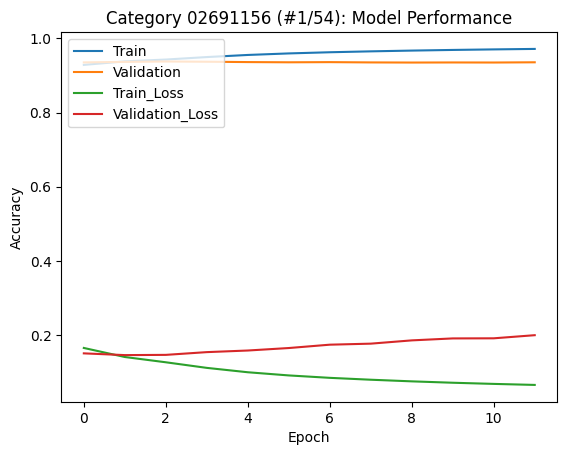

Starting training model for category #2/5: 02747177
x_train shape: (2744, 128, 128, 1)
x_test shape: (686, 128, 128, 1)
y_train shape: (2744, 32, 32, 32, 1)
y_test shape: (686, 32, 32, 32, 1)
Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7294
Epoch 1: val_accuracy improved from -inf to 0.75026, saving model to models/128x32\02747177.keras
69/69 [==============================] - 30s 434ms/step - loss: 0.5229 - accuracy: 0.7294 - val_loss: 0.4559 - val_accuracy: 0.7503
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.7628
Epoch 2: val_accuracy improved from 0.75026 to 0.79765, saving model to models/128x32\02747177.keras
69/69 [==============================] - 29s 421ms/step - loss: 0.4290 - accuracy: 0.7628 - val_loss: 0.4042 - val_accuracy: 0.7976
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8179
Epoch 3: val_accuracy improved from 0.79765 to 0.82246, savi

INFO:tensorflow:Assets written to: ram://30fac649-5509-4711-a198-37f6b1763a3c/assets


INFO:tensorflow:Assets written to: ram://30fac649-5509-4711-a198-37f6b1763a3c/assets


Evaluating best model on category 02747177, input: 128, output: 32.
22/22 [==============================] - 10s 459ms/step - loss: 0.3758 - accuracy: 0.8901
Test Loss: 0.37582001090049744, Test Accuracy: 0.8901155591011047


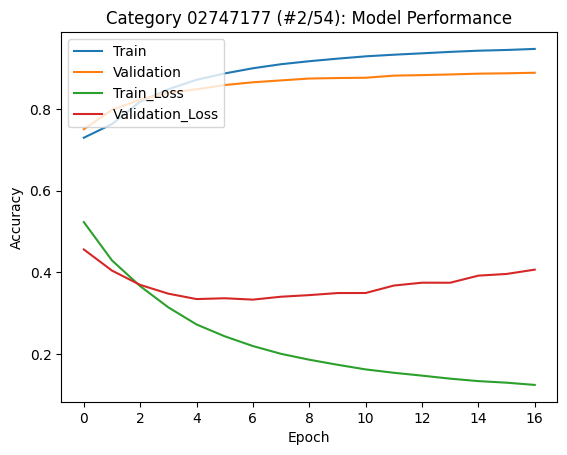

Starting training model for category #3/5: 02773838
x_train shape: (664, 128, 128, 1)
x_test shape: (166, 128, 128, 1)
y_train shape: (664, 32, 32, 32, 1)
y_test shape: (166, 32, 32, 32, 1)
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7005
Epoch 1: val_accuracy improved from -inf to 0.74924, saving model to models/128x32\02773838.keras
17/17 [==============================] - 22s 1s/step - loss: 0.6556 - accuracy: 0.7005 - val_loss: 0.5643 - val_accuracy: 0.7492
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7498
Epoch 2: val_accuracy improved from 0.74924 to 0.75377, saving model to models/128x32\02773838.keras
17/17 [==============================] - 21s 1s/step - loss: 0.5408 - accuracy: 0.7498 - val_loss: 0.5121 - val_accuracy: 0.7538
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7506
Epoch 3: val_accuracy improved from 0.75377 to 0.75380, saving model

INFO:tensorflow:Assets written to: ram://2ae50ca3-f015-4426-9410-a0375674ca01/assets


INFO:tensorflow:Assets written to: ram://2ae50ca3-f015-4426-9410-a0375674ca01/assets


Evaluating best model on category 02773838, input: 128, output: 32.
6/6 [==============================] - 3s 443ms/step - loss: 0.6145 - accuracy: 0.7933
Test Loss: 0.6144761443138123, Test Accuracy: 0.7932652831077576


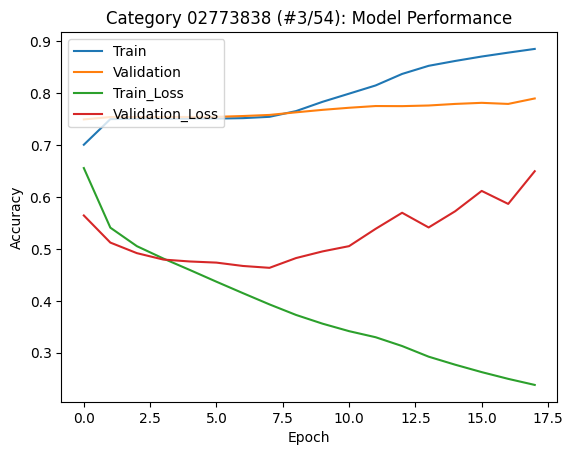

Starting training model for category #4/5: 02801938
x_train shape: (904, 128, 128, 1)
x_test shape: (226, 128, 128, 1)
y_train shape: (904, 32, 32, 32, 1)
y_test shape: (226, 32, 32, 32, 1)
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.7423
Epoch 1: val_accuracy improved from -inf to 0.76618, saving model to models/128x32\02801938.keras
23/23 [==============================] - 23s 1s/step - loss: 0.5476 - accuracy: 0.7423 - val_loss: 0.4895 - val_accuracy: 0.7662
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.7582
Epoch 2: val_accuracy improved from 0.76618 to 0.76628, saving model to models/128x32\02801938.keras
23/23 [==============================] - 23s 1s/step - loss: 0.4655 - accuracy: 0.7582 - val_loss: 0.4332 - val_accuracy: 0.7663
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.7592
Epoch 3: val_accuracy improved from 0.76628 to 0.77062, saving model

INFO:tensorflow:Assets written to: ram://0d828410-cab0-4f64-9ba7-c829ea7938a3/assets


INFO:tensorflow:Assets written to: ram://0d828410-cab0-4f64-9ba7-c829ea7938a3/assets


Evaluating best model on category 02801938, input: 128, output: 32.
8/8 [==============================] - 4s 422ms/step - loss: 0.5071 - accuracy: 0.8802
Test Loss: 0.5070503950119019, Test Accuracy: 0.8802471160888672


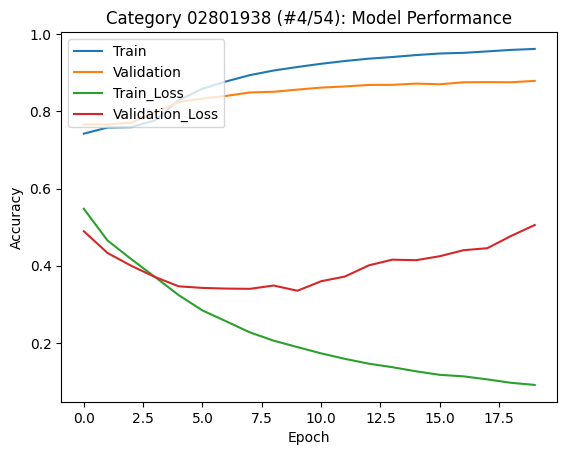

Starting training model for category #5/5: 02808440
x_train shape: (6848, 128, 128, 1)
x_test shape: (1712, 128, 128, 1)
y_train shape: (6848, 32, 32, 32, 1)
y_test shape: (1712, 32, 32, 32, 1)
Epoch 1/100
172/172 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.7266
Epoch 1: val_accuracy improved from -inf to 0.75572, saving model to models/128x32\02808440.keras
172/172 [==============================] - 55s 316ms/step - loss: 0.5163 - accuracy: 0.7266 - val_loss: 0.4767 - val_accuracy: 0.7557
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.7689
Epoch 2: val_accuracy improved from 0.75572 to 0.77538, saving model to models/128x32\02808440.keras
172/172 [==============================] - 44s 257ms/step - loss: 0.4523 - accuracy: 0.7689 - val_loss: 0.4461 - val_accuracy: 0.7754
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.7905
Epoch 3: val_accuracy improved from 0.77538 to 0

INFO:tensorflow:Assets written to: ram://1de4cdd5-272a-4a13-9b7e-a10a91ad195c/assets


INFO:tensorflow:Assets written to: ram://1de4cdd5-272a-4a13-9b7e-a10a91ad195c/assets


Evaluating best model on category 02808440, input: 128, output: 32.
54/54 [==============================] - 26s 477ms/step - loss: 0.4326 - accuracy: 0.7871
Test Loss: 0.43264785408973694, Test Accuracy: 0.7871068716049194


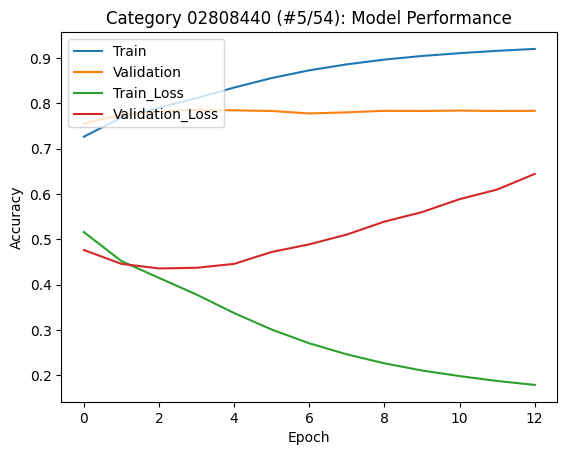

In [11]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+1)}/{len(categories)}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', 'metrics.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()
    

train_models_all_categories(categories[:5],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2)

# TO-DO: output shape param actually doesn't do anything for now, it should update model output shape

Starting training model for category #6/10: 02818832
x_train shape: (1864, 128, 128, 1)
x_test shape: (466, 128, 128, 1)
y_train shape: (1864, 32, 32, 32, 1)
y_test shape: (466, 32, 32, 32, 1)
Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.7072
Epoch 1: val_accuracy improved from -inf to 0.74839, saving model to models/128x32\02818832.keras
47/47 [==============================] - 26s 552ms/step - loss: 0.6181 - accuracy: 0.7072 - val_loss: 0.5502 - val_accuracy: 0.7484
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7510
Epoch 2: val_accuracy did not improve from 0.74839
47/47 [==============================] - 6s 117ms/step - loss: 0.5274 - accuracy: 0.7510 - val_loss: 0.5259 - val_accuracy: 0.7484
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7510
Epoch 3: val_accuracy improved from 0.74839 to 0.74841, saving model to models/128x32\02818832.keras
47/47 [==

INFO:tensorflow:Assets written to: ram://6bff0eeb-5bc6-4050-ad67-230dac23aec4/assets


INFO:tensorflow:Assets written to: ram://6bff0eeb-5bc6-4050-ad67-230dac23aec4/assets


Evaluating best model on category 02818832, input: 128, output: 32.
15/15 [==============================] - 8s 499ms/step - loss: 0.5061 - accuracy: 0.7602
Test Loss: 0.5060576796531677, Test Accuracy: 0.7601515650749207


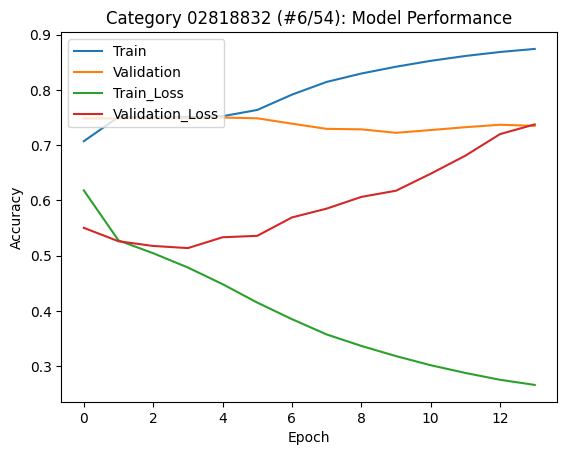

Starting training model for category #7/10: 02828884
x_train shape: (14504, 128, 128, 1)
x_test shape: (3626, 128, 128, 1)
y_train shape: (14504, 32, 32, 32, 1)
y_test shape: (3626, 32, 32, 32, 1)
Epoch 1/100
363/363 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8031
Epoch 1: val_accuracy improved from -inf to 0.81405, saving model to models/128x32\02828884.keras
363/363 [==============================] - 68s 186ms/step - loss: 0.4174 - accuracy: 0.8031 - val_loss: 0.3591 - val_accuracy: 0.8141
Epoch 2/100
363/363 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8341
Epoch 2: val_accuracy improved from 0.81405 to 0.84453, saving model to models/128x32\02828884.keras
363/363 [==============================] - 62s 172ms/step - loss: 0.3433 - accuracy: 0.8341 - val_loss: 0.3302 - val_accuracy: 0.8445
Epoch 3/100
363/363 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8556
Epoch 3: val_accuracy improved from 0.84453 t

INFO:tensorflow:Assets written to: ram://29420365-fe82-48f2-af97-6570f795c6f9/assets


INFO:tensorflow:Assets written to: ram://29420365-fe82-48f2-af97-6570f795c6f9/assets


Evaluating best model on category 02828884, input: 128, output: 32.
114/114 [==============================] - 57s 502ms/step - loss: 0.3916 - accuracy: 0.8579
Test Loss: 0.39157602190971375, Test Accuracy: 0.8578968644142151


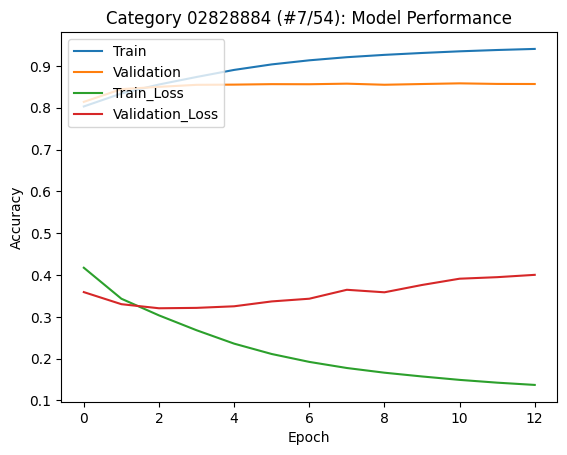

Starting training model for category #8/10: 02843684
x_train shape: (584, 128, 128, 1)
x_test shape: (146, 128, 128, 1)
y_train shape: (584, 32, 32, 32, 1)
y_test shape: (146, 32, 32, 32, 1)
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7235
Epoch 1: val_accuracy improved from -inf to 0.76261, saving model to models/128x32\02843684.keras
15/15 [==============================] - 26s 2s/step - loss: 0.6010 - accuracy: 0.7235 - val_loss: 0.5364 - val_accuracy: 0.7626
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7679
Epoch 2: val_accuracy improved from 0.76261 to 0.76280, saving model to models/128x32\02843684.keras
15/15 [==============================] - 22s 2s/step - loss: 0.5000 - accuracy: 0.7679 - val_loss: 0.4878 - val_accuracy: 0.7628
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.7679
Epoch 3: val_accuracy improved from 0.76280 to 0.76281, saving mode

INFO:tensorflow:Assets written to: ram://e0f5331f-e3c4-4048-9294-7f59e2039202/assets


INFO:tensorflow:Assets written to: ram://e0f5331f-e3c4-4048-9294-7f59e2039202/assets


Evaluating best model on category 02843684, input: 128, output: 32.
5/5 [==============================] - 2s 424ms/step - loss: 0.6643 - accuracy: 0.7928
Test Loss: 0.6643093824386597, Test Accuracy: 0.7928054928779602


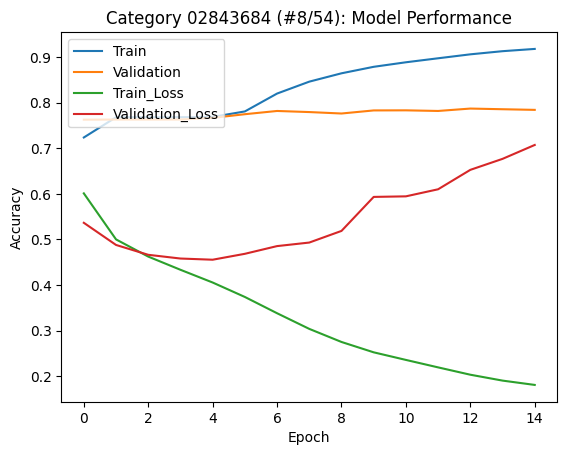

Starting training model for category #9/10: 02871439
x_train shape: (3616, 128, 128, 1)
x_test shape: (904, 128, 128, 1)
y_train shape: (3616, 32, 32, 32, 1)
y_test shape: (904, 32, 32, 32, 1)
Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.6061
Epoch 1: val_accuracy improved from -inf to 0.63788, saving model to models/128x32\02871439.keras
91/91 [==============================] - 32s 348ms/step - loss: 0.6950 - accuracy: 0.6061 - val_loss: 0.6643 - val_accuracy: 0.6379
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6482
Epoch 2: val_accuracy improved from 0.63788 to 0.65116, saving model to models/128x32\02871439.keras
91/91 [==============================] - 31s 337ms/step - loss: 0.6471 - accuracy: 0.6482 - val_loss: 0.6384 - val_accuracy: 0.6512
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6688
Epoch 3: val_accuracy improved from 0.65116 to 0.67573, sav

INFO:tensorflow:Assets written to: ram://768d74bd-1271-457d-abea-fa1ec34d2825/assets


INFO:tensorflow:Assets written to: ram://768d74bd-1271-457d-abea-fa1ec34d2825/assets


Evaluating best model on category 02871439, input: 128, output: 32.
29/29 [==============================] - 14s 470ms/step - loss: 0.6743 - accuracy: 0.6867
Test Loss: 0.6743332147598267, Test Accuracy: 0.686691164970398


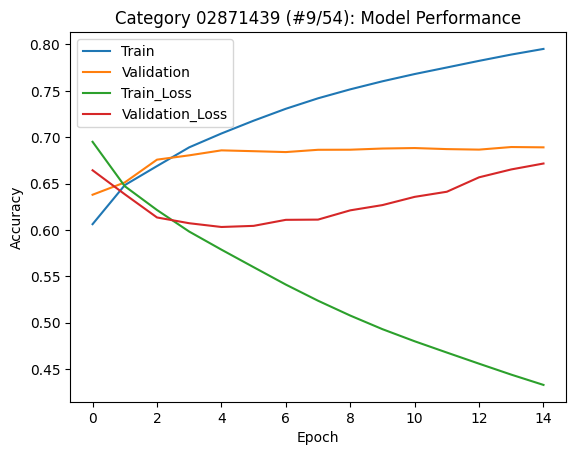

Starting training model for category #10/10: 02876657
x_train shape: (3984, 128, 128, 1)
x_test shape: (996, 128, 128, 1)
y_train shape: (3984, 32, 32, 32, 1)
y_test shape: (996, 32, 32, 32, 1)
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.7273
Epoch 1: val_accuracy improved from -inf to 0.74095, saving model to models/128x32\02876657.keras
100/100 [==============================] - 33s 326ms/step - loss: 0.4991 - accuracy: 0.7273 - val_loss: 0.4319 - val_accuracy: 0.7409
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.7718
Epoch 2: val_accuracy improved from 0.74095 to 0.80787, saving model to models/128x32\02876657.keras
100/100 [==============================] - 36s 363ms/step - loss: 0.4042 - accuracy: 0.7718 - val_loss: 0.3883 - val_accuracy: 0.8079
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8320
Epoch 3: val_accuracy improved from 0.80787 to 0

INFO:tensorflow:Assets written to: ram://d922579a-bab0-405e-a3c6-2381b1bd90c1/assets


INFO:tensorflow:Assets written to: ram://d922579a-bab0-405e-a3c6-2381b1bd90c1/assets


Evaluating best model on category 02876657, input: 128, output: 32.
32/32 [==============================] - 15s 463ms/step - loss: 0.2244 - accuracy: 0.9343
Test Loss: 0.22443266212940216, Test Accuracy: 0.9343471527099609


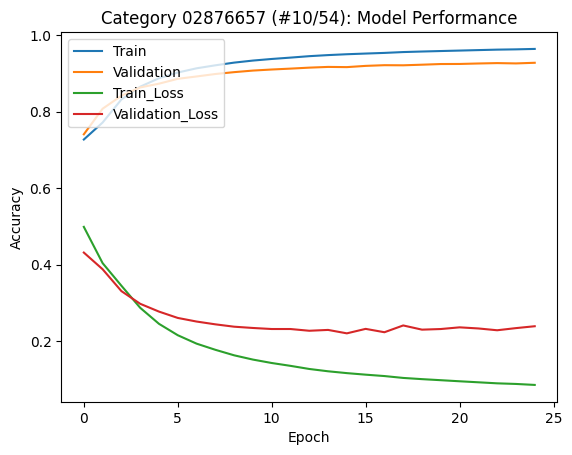

In [12]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()


train_models_all_categories(categories[5:10],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=5)

Starting training model for category #11/20: 02880940
x_train shape: (1488, 128, 128, 1)
x_test shape: (372, 128, 128, 1)
y_train shape: (1488, 32, 32, 32, 1)
y_test shape: (372, 32, 32, 32, 1)
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7772
Epoch 1: val_accuracy improved from -inf to 0.80165, saving model to models/128x32\02880940.keras
38/38 [==============================] - 26s 672ms/step - loss: 0.4847 - accuracy: 0.7772 - val_loss: 0.3703 - val_accuracy: 0.8016
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.80165 to 0.80692, saving model to models/128x32\02880940.keras
38/38 [==============================] - 27s 719ms/step - loss: 0.3587 - accuracy: 0.8021 - val_loss: 0.3380 - val_accuracy: 0.8069
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8152
Epoch 3: val_accuracy improved from 0.80692 to 0.83468, sa

INFO:tensorflow:Assets written to: ram://a10ec76b-47b1-404b-b61d-a89129bf117f/assets


INFO:tensorflow:Assets written to: ram://a10ec76b-47b1-404b-b61d-a89129bf117f/assets


Evaluating best model on category 02880940, input: 128, output: 32.
12/12 [==============================] - 6s 484ms/step - loss: 0.1723 - accuracy: 0.9508
Test Loss: 0.17229370772838593, Test Accuracy: 0.9507592916488647


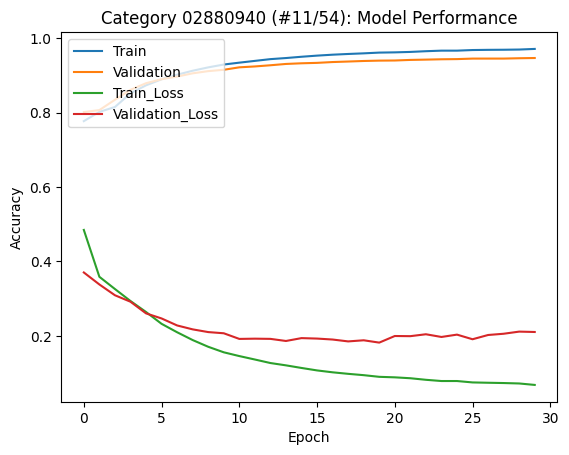

Starting training model for category #12/20: 02924116
x_train shape: (7512, 128, 128, 1)
x_test shape: (1878, 128, 128, 1)
y_train shape: (7512, 32, 32, 32, 1)
y_test shape: (1878, 32, 32, 32, 1)
Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6760
Epoch 1: val_accuracy improved from -inf to 0.70194, saving model to models/128x32\02924116.keras
188/188 [==============================] - 46s 243ms/step - loss: 0.5922 - accuracy: 0.6760 - val_loss: 0.5671 - val_accuracy: 0.7019
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.7063
Epoch 2: val_accuracy improved from 0.70194 to 0.71366, saving model to models/128x32\02924116.keras
188/188 [==============================] - 47s 248ms/step - loss: 0.5604 - accuracy: 0.7063 - val_loss: 0.5518 - val_accuracy: 0.7137
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7260
Epoch 3: val_accuracy improved from 0.71366 to

INFO:tensorflow:Assets written to: ram://ae411ac0-4d6a-4e76-9e6f-d4bc37584780/assets


INFO:tensorflow:Assets written to: ram://ae411ac0-4d6a-4e76-9e6f-d4bc37584780/assets


Evaluating best model on category 02924116, input: 128, output: 32.
59/59 [==============================] - 36s 599ms/step - loss: 0.5481 - accuracy: 0.7216
Test Loss: 0.5481075048446655, Test Accuracy: 0.7216292023658752


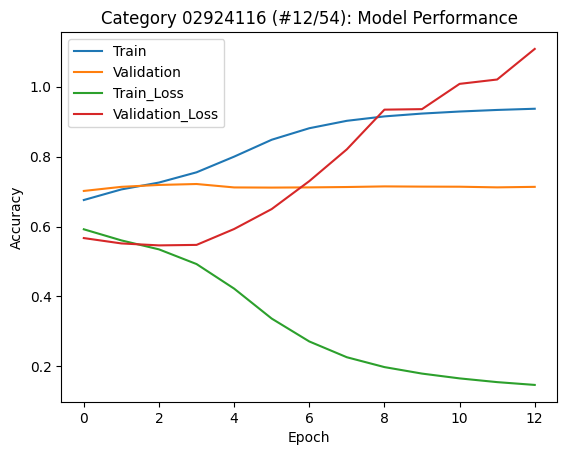

Starting training model for category #13/20: 02933112
x_train shape: (12568, 128, 128, 1)
x_test shape: (3142, 128, 128, 1)
y_train shape: (12568, 32, 32, 32, 1)
y_test shape: (3142, 32, 32, 32, 1)
Epoch 1/100
315/315 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.6699
Epoch 1: val_accuracy improved from -inf to 0.70010, saving model to models/128x32\02933112.keras
315/315 [==============================] - 61s 190ms/step - loss: 0.6107 - accuracy: 0.6699 - val_loss: 0.5769 - val_accuracy: 0.7001
Epoch 2/100
315/315 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7070
Epoch 2: val_accuracy improved from 0.70010 to 0.71071, saving model to models/128x32\02933112.keras
315/315 [==============================] - 59s 186ms/step - loss: 0.5662 - accuracy: 0.7070 - val_loss: 0.5594 - val_accuracy: 0.7107
Epoch 3/100
315/315 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7199
Epoch 3: val_accuracy improved from 0.71071 

INFO:tensorflow:Assets written to: ram://66110bf9-b9a9-4c31-821a-fb46ffbcbf87/assets


INFO:tensorflow:Assets written to: ram://66110bf9-b9a9-4c31-821a-fb46ffbcbf87/assets


Evaluating best model on category 02933112, input: 128, output: 32.
99/99 [==============================] - 50s 507ms/step - loss: 0.5444 - accuracy: 0.7206
Test Loss: 0.5444342494010925, Test Accuracy: 0.7206225395202637


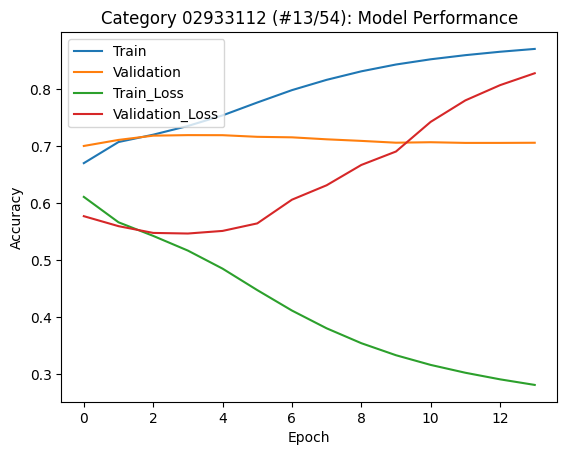

Starting training model for category #14/20: 02942699
x_train shape: (904, 128, 128, 1)
x_test shape: (226, 128, 128, 1)
y_train shape: (904, 32, 32, 32, 1)
y_test shape: (226, 32, 32, 32, 1)
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7597
Epoch 1: val_accuracy improved from -inf to 0.77748, saving model to models/128x32\02942699.keras
23/23 [==============================] - 23s 1s/step - loss: 0.5645 - accuracy: 0.7597 - val_loss: 0.5114 - val_accuracy: 0.7775
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7807
Epoch 2: val_accuracy did not improve from 0.77748
23/23 [==============================] - 3s 121ms/step - loss: 0.4956 - accuracy: 0.7807 - val_loss: 0.4960 - val_accuracy: 0.7775
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.7807
Epoch 3: val_accuracy did not improve from 0.77748
23/23 [==============================] - 3s 122ms/step - loss: 

INFO:tensorflow:Assets written to: ram://5abebae5-41f9-4778-a157-e2ecc62c76a0/assets


INFO:tensorflow:Assets written to: ram://5abebae5-41f9-4778-a157-e2ecc62c76a0/assets


Evaluating best model on category 02942699, input: 128, output: 32.
8/8 [==============================] - 4s 477ms/step - loss: 0.5071 - accuracy: 0.7883
Test Loss: 0.5070977210998535, Test Accuracy: 0.788343608379364


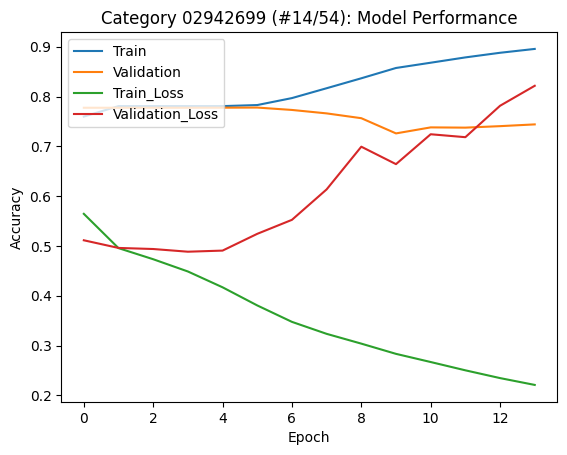

Starting training model for category #15/20: 02946921
x_train shape: (864, 128, 128, 1)
x_test shape: (216, 128, 128, 1)
y_train shape: (864, 32, 32, 32, 1)
y_test shape: (216, 32, 32, 32, 1)
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7192
Epoch 1: val_accuracy improved from -inf to 0.75652, saving model to models/128x32\02946921.keras
22/22 [==============================] - 38s 2s/step - loss: 0.5335 - accuracy: 0.7192 - val_loss: 0.4342 - val_accuracy: 0.7565
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.7752
Epoch 2: val_accuracy improved from 0.75652 to 0.79837, saving model to models/128x32\02946921.keras
22/22 [==============================] - 29s 1s/step - loss: 0.3846 - accuracy: 0.7752 - val_loss: 0.3713 - val_accuracy: 0.7984
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8236
Epoch 3: val_accuracy improved from 0.79837 to 0.83434, saving mod

MemoryError: Unable to allocate 1.00 GiB for an array with shape (65536, 4096) and data type float32

In [13]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()


train_models_all_categories(categories[10:20],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=10)

In [12]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, images_per_voxel, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{images_per_voxel}x{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, images_per_voxel, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{images_per_voxel}x{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, images_per_voxel, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()


train_models_all_categories(categories,
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=0)

Starting training model for category #1/54: 02691156
x_train shape: (3236, 128, 128, 1)
x_test shape: (809, 128, 128, 1)
y_train shape: (3236, 32, 32, 32, 1)
y_test shape: (809, 32, 32, 32, 1)
Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9081
Epoch 1: val_accuracy improved from -inf to 0.91264, saving model to models/1x128x32\02691156.keras
81/81 [==============================] - 32s 385ms/step - loss: 0.1978 - accuracy: 0.9081 - val_loss: 0.1730 - val_accuracy: 0.9126
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9192
Epoch 2: val_accuracy improved from 0.91264 to 0.92369, saving model to models/1x128x32\02691156.keras
81/81 [==============================] - 39s 477ms/step - loss: 0.1551 - accuracy: 0.9192 - val_loss: 0.1563 - val_accuracy: 0.9237
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9305
Epoch 3: val_accuracy improved from 0.92369 to 0.93181,

FileNotFoundError: [Errno 2] No such file or directory: 'history/1x128x32/02691156.pkl'

### Part V. Validating Model <a class="anchor" id="#part-5"></a>

In [5]:
# Convert a single testing image into NPY
save_npy_array_from_png(['Untitled.png'], (128, 128), npy_filename='test_image')

Starting pipeline...
100.0% (1 files done)

Final NumPy array shape: (1, 128, 128, 1)


In [6]:
# Load the image and reshape adding a batch dimension for prediction
image_npy = np.load('test_image.npy')
image_npy = image_npy.reshape(1, 128, 128, 1)

# Make a Prediction and remove batch channel from prediction
model = tf.keras.models.load_model('/_Projects/Shapenet/app/02691156.keras')
predicted_voxel = model.predict(image_npy)
predicted_voxel = predicted_voxel[0, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(np.uint8)

1/1 [==============================] - 3s 3s/step


In [7]:
def save_voxel_grid_to_obj(voxel_grid, obj_filename):
    # Vertices and faces for an individual cube (each voxel)
    vertex_offsets = [
        (0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)
    ]
    
    face_offsets = [
        (0, 1, 2, 3), # Bottom
        (4, 5, 6, 7), # Top
        (0, 1, 5, 4), # Front
        (2, 3, 7, 6), # Back
        (1, 2, 6, 5), # Right
        (3, 0, 4, 7)  # Left
    ]

    vertices = []
    faces = []
    vertex_index = 1

    # Iterate through the 3D array and process each voxel
    for x in range(voxel_grid.shape[0]):
        for y in range(voxel_grid.shape[1]):
            for z in range(voxel_grid.shape[2]):
                if voxel_grid[x, y, z] == 1:  # Only process occupied voxels (value 1)
                    # Add vertices for this voxel's cube
                    for dx, dy, dz in vertex_offsets:
                        vertices.append((x + dx, y + dy, z + dz))

                    # Add faces using the latest 8 vertices
                    for face in face_offsets:
                        faces.append((
                            vertex_index + face[0],
                            vertex_index + face[1],
                            vertex_index + face[2],
                            vertex_index + face[3]
                        ))

                    # Update the vertex index
                    vertex_index += 8

    # Write vertices and faces to an OBJ file
    with open(obj_filename, 'w') as obj_file:
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        for face in faces:
            obj_file.write(f"f {face[0]} {face[1]} {face[2]} {face[3]}\n")


# Save the voxel grid to an OBJ file
save_voxel_grid_to_obj(predicted_voxel_binary, 'test_voxel.obj')